In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math
import allel

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.dataset import Haplotype
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import inference

# load the model and use valid data 

In [5]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model

labels_path = osp.join(os.environ['OUT_PATH'],'dogs/labels/data_id_3_umap')
data_path = osp.join(os.environ['OUT_PATH'],'dogs/labels/data_id_3_umap')
models_path=osp.join(os.environ['OUT_PATH'],'dogs/training/Model_Q_exp_id_1_data_id_3_umap/') 
dataset_type='test'

In [6]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
yaml_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(yaml_path), "No json configuration file found at {}".format(yaml_path)
params = Params(yaml_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.balancedLoss=False
results, test_dataset,_,_=inference.main(config, params)

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (36, 524864)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(36, 524864)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.4642 secs
Finished 'pop_mapping' in 0.1645 secs
Finished 'pop_mapping' in 0.1623 secs
Finished 'transform_data' in 52.9767 secs
Finished '__init__' in 141.1096 secs
Parameter count for model AuxNetwork:52468203
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:52612519
Finished 'load_model' in 3.0121 secs
best val loss metrics : {'loss_main': 0.315209464211453, 'loss_aux': 0.8947960030149106, 'gcd': None, 'mse': 0.19268142796993307, 'smooth_l1': 0.09475352589803951, 'weighted_loss': 0.315209464211453}
at epoch : 110
train loss metrics: {'loss_main': 0.2677480816865698, 'loss_aux': 0.3831430327689332, 'gcd': None, 'mse': 0.07214449174141804, 'smooth_l1': 0.03606346916806092, 'weighted_loss': 0.2677480816865698}
best val cp metrics : {'loss_cp': 0.26504278590152375, 'prMetrics': OrderedDict([('Precision', array(0.0701982)), ('Recall', array(0.87129318)), ('Accur

In [7]:
train_dataset = Haplotype("train", params, data_path, labels_path=labels_path)

INFO: __init__:src.main.dataset: Loading train Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (396, 524864)
INFO: __init__:src.main.dataset: y_labels data :(396, 524864)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.4682 secs
Finished 'pop_mapping' in 0.1701 secs
Finished 'pop_mapping' in 0.1705 secs
Finished 'transform_data' in 61.8312 secs
Finished '__init__' in 167.9789 secs


In [8]:
results.t_accr, results.t_cp_accr

({'gcd': None,
  'loss_aux': 0.814781268434715,
  'loss_main': 0.2640977906667364,
  'mse': 0.12195931785850404,
  'smooth_l1': 0.059274340687805335,
  'weighted_loss': 0.2640977906667364},
 {'loss_cp': 0.1719339909348697,
  'prMetrics': OrderedDict([('Precision', array(0.1253122)),
               ('Recall', array(0.89666628)),
               ('Accuracy', array(0.95649309)),
               ('A_major', array(0.95690503)),
               ('BalancedAccuracy', 0.9267856581060472)])})

In [9]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [10]:
#load dataset of admixed population
# ref_map_a=pd.read_csv(osp.join(os.environ['OUT_PATH'],'dogs/ref_map_a.tsv'), sep='\t')
# ref_map_expt1 = pd.read_csv(osp.join(os.environ['OUT_PATH'],'dogs/ref_map_expt1_w_wolf_coyote.tsv'), sep='\t')

In [11]:
# ref_map_expt1=ref_map_expt1[ref_map_a.columns]

In [12]:
# ref_map_a, ref_map_expt1

In [13]:
# only_admixed = ref_map_a[~ref_map_a['Sample'].isin(ref_map_expt1['Sample'])].dropna()

In [14]:
# only_admixed

In [15]:
#now from the vcf of expt_e, get chr22_filtered for an admixed sample
# vcf=allel.read_vcf(osp.join(os.environ['OUT_PATH'],'dogs/sm_a/chr22/chr22_filtered.vcf'))

In [16]:
# vcf['samples'].shape

In [17]:
# vcf_npy=vcf2npy(osp.join(os.environ['OUT_PATH'],'dogs/sm_a/chr22/chr22_filtered.vcf'))

In [18]:
# vcf_npy.shape

In [19]:
# i=np.where(vcf['samples']=='Xoloitzcuintli01')[0].item()
# vcf_sample=vcf_npy[2*i]

In [20]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 464.8902 secs


In [21]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
rev_sp_dict={v:k for k,v in superop_dict.items()}

In [22]:
superop_dict

{'Basenji': 5,
 'Coyote': 7,
 'East': 6,
 'Greyhound': 8,
 'Hound': 2,
 'Husky': 1,
 'Retriever': 0,
 'Terrier': 4,
 'Tibetan_Mastiff': 9,
 'Wolf': 3}

In [23]:
idxOfInterest=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["Wolf"])[0])
# idxOfInterest

In [24]:
# index = 2500
# index=2620
# index=51
# index=3000
# index=3100
index=1625
# index=np.random.choice(idxOfInterest)
print(index)
true_cpsSample=cp_target[index,:]
y_predSample=results.t_out.coord_main[index,:]
y_trueSample=test_dataset.data['y'][index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
superpops = test_dataset.data['superpop'].reshape(-1,)
superPopSample=test_dataset.data['superpop'][index,:]
SpNamesSample=[rev_sp_dict[i] for i in superPopSample.astype(int)]

1625


In [25]:
y_predSample.shape

(524, 3)

In [26]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, len(true_cpsSample))
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [27]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [28]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(seqlen, i+remWin)
    pred_cps_BOCD[low:high]=1

In [29]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.reshape(-1,3))

Finished 'nearestNeighbourMapping' in 0.0378 secs


In [30]:
mappedSpArr.shape

(524,)

In [31]:
y_predsTrue=train_dataset.data['y'].reshape(-1,3)
superpopsTrue=train_dataset.data['superpop'].reshape(-1,)

In [32]:
def linear_gradient(start_rgb, finish_rgb, n):
    ''' returns a gradient list of (n) colors between
      two rgb colors. start_rgb and finish_rgb
       '''
    # Initilize a list of the output colors with the starting color
    RGB_list = [start_rgb]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            (start_rgb[j] + (float(t)/(n-1))*(finish_rgb[j]-start_rgb[j]))
            for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)
    
    return RGB_list

In [33]:
def getColorsPop(granularpopSample, superPopSample, colorsSP_dict):
    counterSPUsed={k:0 for k in range(len(list(superop_dict.keys())))}
    haploGp ={}
    gpMap2Sp_Color={}
    for i in np.unique(granularpopSample):
        idx=np.nonzero(granularpopSample==i)[0][0]
        sp=superPopSample[idx]
        colorIdx=3*counterSPUsed[sp]+3 # because we want to pick alternate colors separated by 2 hops
        gpMap2Sp_Color[i]=(sp,colorIdx)
        counterSPUsed[sp] +=1
    
    spGradient=getGradient(counterSPUsed, colorsSP_dict)
    
    for i in np.unique(granularpopSample):
        haploGp[i]=spGradient[gpMap2Sp_Color[i][0]][gpMap2Sp_Color[i][1]]
    
    return haploGp, counterSPUsed, gpMap2Sp_Color

In [34]:
continentaPops=list(superop_dict.values())
colorsPop = sns.color_palette("bright", 10)
# del colorsPop[1]
# del colorsPop[4]
# del colorsPop[5]
colorsSP_dict = {k:v for k,v in zip(continentaPops, colorsPop)}

def getGradient(counterSPUsed, colorsSP_dict):
    spGradient={}
    for k,v in colorsSP_dict.items():
        if counterSPUsed[k]>0:
            if k<=len(colorsSP_dict)-2:
                finish_rgb=k+1
            else:
                finish_rgb=0
#             if k == 3:
#                 spGradient[k]=linear_gradient(start_rgb=[147.0/255.0, 112.0/255.0, 219.0/255.0], finish_rgb=[139.0/255.0, 0.0/255.0, 139.0/255.0],\
#                 n= max(15,3*counterSPUsed[k]+3))                
#             else:
#                 spGradient[k]=linear_gradient(start_rgb=v, finish_rgb=colorsSP_dict[finish_rgb],\
#                 n= max(15,3*counterSPUsed[k]+3))
            spGradient[k]=linear_gradient(start_rgb=v, finish_rgb=[1.0, 1.0, 1.0],\
            n= max(10,3*counterSPUsed[k]+3))

    return spGradient
    
uniqueGpSample=np.unique(namesSample)
uniqueSpSample=np.unique(SpNamesSample)
colors_Gp_dict, counterSPUsed, gpMap2Sp_Color=getColorsPop(granularpopSample, superPopSample, colorsSP_dict)

In [35]:
@timer
def plot_all(ax, y_preds, superpops, superop_dict, reduce_alpha=0.03, size=5, zorder=-1,**kwargs):
    plt.rcParams['lines.solid_capstyle'] = 'round'
    def expand(x, y, z, gap=1e-4):
        add = np.tile([0, gap, np.nan], len(x))
        x1 = np.repeat(x, 3) + add
        y1 = np.repeat(y, 3) + add
        z1 = np.repeat(z, 3) + add
        return x1, y1, z1
    
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    print(superop_dict)
    continentaPops=list(superop_dict.values())
    colors_pop = sns.color_palette("rainbow", 10)
    colors_pop_dict = {k:v for k,v in zip(continentaPops, colors_pop)}
    
    alpha=[1.0]*len(y_preds)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
        
    colors_pop_dict2={}  
    for pop in continentaPops:
        start_rgb=colors_pop_dict[pop]
        finish_rgb=(1.,1.,1.)
        n=10
        colors_pop_dict2[pop]=linear_gradient(start_rgb, finish_rgb, n)[0]
    for pop in continentaPops:
        idx = np.where(superpops==pop)[0]
        ax.plot(*expand(y_preds[idx,0], y_preds[idx,1], y_preds[idx,2]), \
               color = colors_pop_dict[pop], alpha=0.2, linewidth=12) 
    
    return colors_pop_dict

In [36]:
@timer
def plot_sample(granularPopSample, y_predSample, y_trueSample, superop_dict, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_preds=kwargs.get('y_preds')
    superpops=kwargs.get('superpops')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    superPopSample=kwargs.get('superPopSample')
    
    
    fig, ax = plt.subplots(figsize=(13,13))
    plt.rcParams['hatch.color']='grey'
    
    gs1 = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[13,2,2])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax1.set_xlim(np.array([-2,2])*1.)
    ax1.set_ylim(np.array([-2,2])*1.)
    ax1.set_zlim(np.array([-2,2])*.77)
    ax2=fig.add_subplot(gs1[1])
    ax3=fig.add_subplot(gs1[2])
    for axis in [ax, ax2, ax3]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5)
    plt.subplots_adjust(hspace=0.01)
    
    #plot background
    if backgroundAxis:
        colorsPop_sp_dict =plot_all(ax1, y_preds, superpops, superop_dict, cpShow=False)
    else:
        continentaPops=list(superop_dict.values())
        colorsPop_sp = sns.color_palette("rainbow", 10)
        colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colorsPop_sp)}
        
    patches=[]
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
    lgnd = ax1.legend(handles=patches, fontsize=20, loc="upper left", bbox_to_anchor=(0.06, 0.49, 1., .5))

    ax1.add_artist(lgnd)
    #colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopSample)))
    #colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopSample), colors_pop)}
    colors_Gp_dict,_,_=getColorsPop(granularpopSample, superPopSample, colorsPop_sp_dict)
    colors_pop_dict=colors_Gp_dict
    
    alpha=[1]*len(y_predSample)
    
    unknownIdx=np.nonzero(pred_cps)[0]
    print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)/len(y_predSample)}")
    granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
    colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
    mappedSpArr[unknownIdx]=-1
    colorsPop_sp_dict[-1]=(0.9,0.9,0.9) # grey color
    knownIdx=[i for i in range(len(granularPopNames)) if granularPopNames[i]!="UNK"]
    
    #predictions
    ax1.scatter(y_predSample[knownIdx,0], y_predSample[knownIdx,1], y_predSample[knownIdx,2],\
    color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in knownIdx], alpha)],\
    s=200, zorder=0, edgecolor='black', linewidth=0.5)
    #changepoints
    if cpShow is True:
        ax1.scatter(y_predSample[unknownIdx,0], y_predSample[unknownIdx,1], y_predSample[unknownIdx,2], facecolor='grey', hatch=3*'+',\
        color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in unknownIdx], alpha)], s=50, zorder=0, marker="D") 
    
    #ToDo: plot only the unique trueSample instead of all the windows
    ax1.scatter(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2],  \
    color = [tuple(colors_pop_dict[x]) for x in granularPopSample], marker='X', s=200, zorder=0, \
    edgecolor='black', linewidth=1.5)
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(ax1.scatter([],[], color = colors_pop_dict[val], marker='o', s=400, edgecolor='black', linewidth=0.5, label = rev_pop_dict[val])) #add training locations
    patches.append(ax1.scatter([],[], color = (1, 1, 1, 0.5), marker='X', s=400, edgecolor='black', linewidth=1.5, label = "Target Location")) #add training locations
    
    patches.append(mpatches.Patch(facecolor = (0.9,0.9,0.9), label = "Changepoint", hatch=3*'+')) 
    #add UNK legend patch separately
    ax1.legend(handles=patches, loc="upper right", fontsize=20, bbox_to_anchor=(-0.22, 0.5, 1., .5))
    
    #chm plot ground truth
    ax2.bar(np.arange(len(y_trueSample)),\
    color=[colors_pop_dict[x] for x in granularPopSample], width=1.0, height=1.02)
    if kwargs.get('title_enable') is not None:
        ax2.set_title('Ground Truth', fontsize=30, y=0.3, loc='left')
    
    #chm plot of predictions
    ax3.bar(knownIdx, 1.02*np.ones(len(mappedSpArr[knownIdx])), \
            color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[knownIdx],alpha)], \
            width=1.0)
    ax3.bar(unknownIdx, 1.02*np.ones(len(mappedSpArr[unknownIdx])), \
        color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[unknownIdx],alpha)], \
        width=1.0, hatch=3*"+")
    if kwargs.get('title_enable') is not None:
        ax3.set_title('Predicted', fontsize=30, y=0.3, loc='left')
    
    xtickOffsetBegin=4
    xtickOffsetEnd=-32
    for ax in [ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=30)
        ax.tick_params(which='minor', width=2, length=10, labelsize=10)
        ax.set_xlim(0, params.n_win)
        ax.set_ylim(0.99,1.09)
        positions = [0+xtickOffsetBegin, int(params.n_win/2), params.n_win+xtickOffsetEnd]
        x_labels = [0, int(params.n_win*params.win_size/2), params.n_win*params.win_size]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
        for tick in ax.xaxis.get_majorticklabels():
            tick.set_horizontalalignment("center")
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4))
    ax2.xaxis.set_ticks_position('bottom')
    ax2.tick_params(which='major', width=2, length=10)
    ax2.tick_params(which='minor', width=2, length=10)
    ax2.set_xlim(0, params.n_win)
    ax2.set_ylim(0.99,1.09)
    ax2.xaxis.set_major_locator(ticker.FixedLocator([]))
    ax2.xaxis.set_major_formatter(ticker.FixedFormatter([]))
    
    plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
    plt.show()
    plt.close('all')

{'Retriever': 0, 'Husky': 1, 'Hound': 2, 'Wolf': 3, 'Terrier': 4, 'Basenji': 5, 'East': 6, 'Coyote': 7, 'Greyhound': 8, 'Tibetan_Mastiff': 9}
Finished 'plot_all' in 0.4628 secs
number of changepoints removed:29,0.05534351145038168


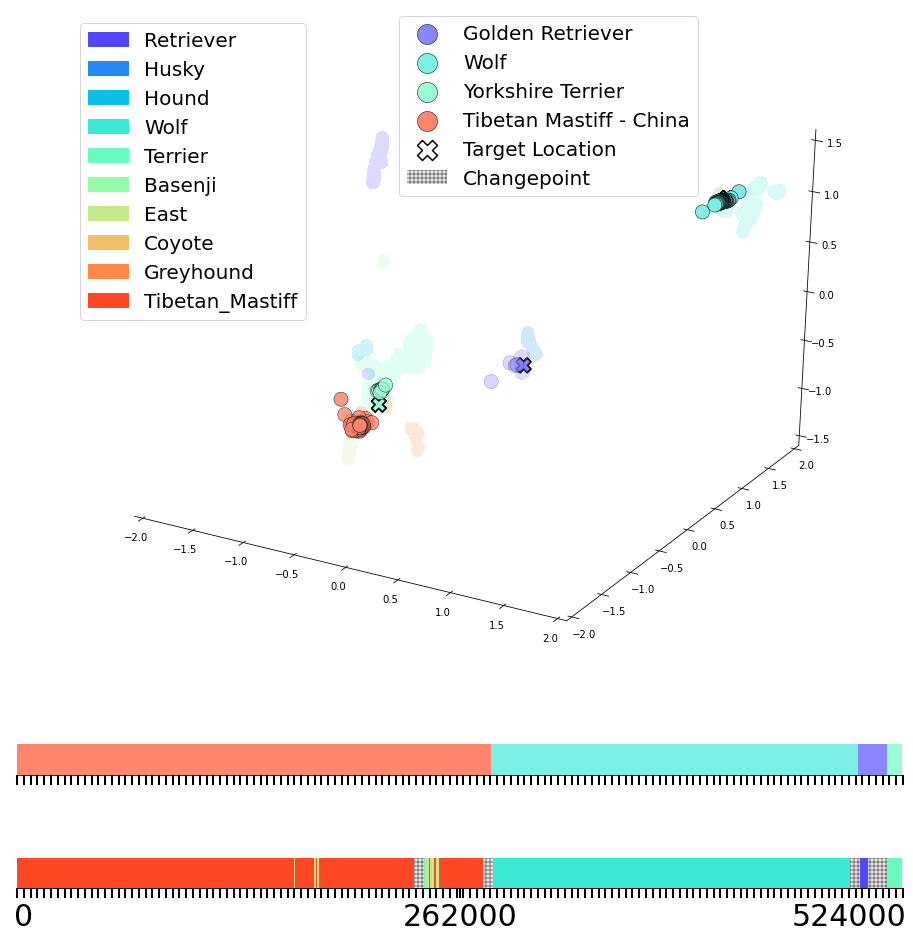

Finished 'plot_sample' in 11.5656 secs


In [37]:
plot_sample(granularpopSample, y_predSample, y_trueSample, superop_dict, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr, \
backgroundAxis=True, y_preds=y_predsTrue, superpops=superpopsTrue, superPopSample=superPopSample, cpShow=False)

In [85]:
y_preds=results.t_out.coord_main
y_predCps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, y_preds.shape[0], y_preds.shape[1])
y_predCps=y_predCps.reshape(-1,)
y_preds=y_preds.reshape(-1,3)
superpops=test_dataset.data['superpop'].reshape(-1,)

In [ ]:
superop_dict

In [ ]:
for k, v in colors_Gp_dict.items():
    print(f"granular_pop:{rev_pop_dict[int(k)]}")
    print(f"superpop:{rev_sp_dict[int(gpMap2Sp_Color[k][0])]}")
    sns.palplot(v)
    plt.show()


In [68]:
# continentaPops=list(superop_dict.keys())
# for i in range(7):
#     print(f"{continentaPops[i]} color")
#     sns.palplot(colorsSP_dict[i])
#     print("gradient color")
#     sns.palplot(spGradient[i])
#     plt.show()
# plt.close('all')

Retriever color
gradient color


NameError: name 'spGradient' is not defined

In [ ]:
granular_pop_dict

## Predictions visualization with ground truth superpops

Finished 'plot_all' in 12.9309 secs


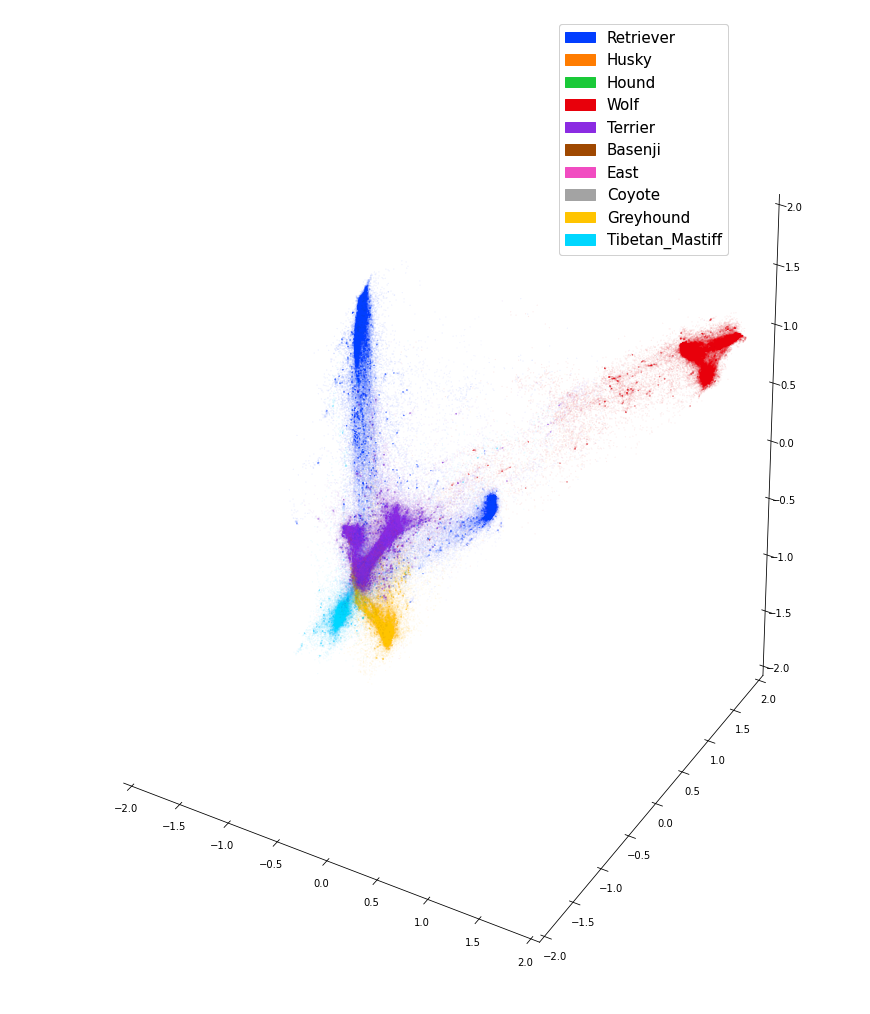

In [51]:
fig, ax = plt.subplots(figsize=(12,14))
gs1 = fig.add_gridspec(nrows=1, ncols=1)
ax1=fig.add_subplot(gs1[0],projection='3d')
ax1.set_xlim(np.array([-2,2]))
ax1.set_ylim(np.array([-2,2]))
ax1.set_zlim(np.array([-2,2]))
for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
    axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis._axinfo["grid"]['color'] = (1,1,1,0)
for axis in [ax, ax1]:
    axis.spines['top'].set_color('none')
    axis.spines['left'].set_color('none')
    axis.spines['right'].set_color('none')
    axis.spines['bottom'].set_color('none')
ax.set_xticks([])
ax.set_yticks([])

plot_all(ax1, y_pred.reshape(-1,3), superpops, superop_dict, reduce_alpha=1.0, size=0.005, zorder=5, cpShow=False)
continentaPops=list(superop_dict.values())
colorsPop_sp = sns.color_palette("bright", 10)
colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colorsPop_sp)}

patches=[]
for k, val in superop_dict.items():
    patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
lgnd = ax1.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
ax1.add_artist(lgnd)
plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
plt.show()

In [44]:
y_pred.shape

(2436, 524, 3)

In [48]:
superpops.shape

(2436, 524)